### Tp Morpion Q Learning 

Ce notebook implémente le jeu du Morpion (Tic-Tac-Toe) ainsi qu’un agent
d’apprentissage par renforcement utilisant l’algorithme de Q-learning.

L’objectif est de :
- Implémenter un environnement de jeu conforme aux règles
- Définir un agent Q-learning tabulaire
- Entraîner l’agent sans affichage graphique
- Évaluer ses performances contre un adversaire aléatoire

In [2]:
import numpy as np
import random
from collections import defaultdict

## Architecture

- **Environnement** : règles du Morpion, coups légaux, détection de fin de partie
- **Agent** : choix d’actions via une politique ε-greedy et mise à jour Q-learning
- **Entraînement** : boucle d’épisodes complète
- **Évaluation** : agent entraîné contre un adversaire aléatoire

## 1. Environnement 

In [3]:
class TicTacToeEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros(9, dtype=int)  # 0 = vide, 1 = X, -1 = O
        self.current_player = 1
        return self.get_state()

    def get_state(self):
        return (tuple(self.board), self.current_player)

    def legal_actions(self):
        return [i for i in range(9) if self.board[i] == 0]

    def step(self, action):
        self.board[action] = self.current_player

        winner = self.check_winner()
        done = winner is not None or len(self.legal_actions()) == 0

        reward = 0
        if done:
            if winner == self.current_player:
                reward = 1
            elif winner is not None:
                reward = -1

        self.current_player *= -1
        return self.get_state(), reward, done

    def check_winner(self):
        wins = [
            (0,1,2),(3,4,5),(6,7,8),
            (0,3,6),(1,4,7),(2,5,8),
            (0,4,8),(2,4,6)
        ]
        for a,b,c in wins:
            s = self.board[a] + self.board[b] + self.board[c]
            if s == 3:
                return 1
            if s == -3:
                return -1
        return None

In [4]:
#test
env = TicTacToeEnv()
print(env.board)
print(env.legal_actions())

[0 0 0 0 0 0 0 0 0]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


## Agent Q-learning

L’agent utilise un Q-learning tabulaire avec une politique ε-greedy.
Les valeurs Q(s, a) sont stockées dans un dictionnaire Python.

In [5]:
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=1.0):
        self.Q = defaultdict(float)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def act(self, state, legal_actions):
        # ε-greedy
        if random.random() < self.epsilon:
            return random.choice(legal_actions)

        # exploitation
        q_vals = [(self.Q[(state, a)], a) for a in legal_actions]
        max_q = max(q_vals, key=lambda x: x[0])[0]
        best_actions = [a for q, a in q_vals if q == max_q]
        return random.choice(best_actions)

    def learn(self, s, a, r, s_next, done, legal_actions_next):
        q_old = self.Q[(s, a)]

        if done:
            target = r
        else:
            target = r + self.gamma * max(
                self.Q[(s_next, a2)] for a2 in legal_actions_next
            )

        self.Q[(s, a)] = q_old + self.alpha * (target - q_old)

In [6]:
agent = QLearningAgent()
env = TicTacToeEnv()

state = env.reset()
action = agent.act(state, env.legal_actions())
print("Action choisie :", action)

Action choisie : 7


L’agent est entraîné contre un adversaire aléatoire.
Chaque épisode correspond à une partie complète de Morpion.
Le paramètre ε décroît progressivement afin de favoriser
l’exploitation des connaissances acquises.

## Entrainement agent 

In [7]:
def train(episodes=50000):
    env = TicTacToeEnv()
    agent = QLearningAgent()

    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            if env.current_player == 1:
                action = agent.act(state, env.legal_actions())
            else:
                action = random.choice(env.legal_actions())

            next_state, reward, done = env.step(action)

            if env.current_player == -1:
                reward = -reward

            agent.learn(
                state,
                action,
                reward,
                next_state,
                done,
                env.legal_actions()
            )

            state = next_state

        agent.epsilon = max(0.05, agent.epsilon * 0.9995)

    return agent

In [8]:
agent = train(episodes=50000)
print("Entraînement terminé")

Entraînement terminé


## Évaluation des performances

L’agent entraîné est évalué contre un adversaire aléatoire
sur 200 parties avec ε = 0 (politique gloutonne).

In [26]:
def evaluate(agent, games=200, epsilon_test=0):
    env = TicTacToeEnv()
    
    # epsilon choisi pour l'évaluation / test manuel
    agent.epsilon = epsilon_test

    win = loss = draw = 0

    for _ in range(games):
        state = env.reset()
        done = False

        while not done:
            if env.current_player == 1:
                action = agent.act(state, env.legal_actions())
            else:
                action = random.choice(env.legal_actions())

            state, reward, done = env.step(action)

        if reward == 1:
            win += 1
        elif reward == -1:
            loss += 1
        else:
            draw += 1

    print(f"\nEpsilon = {epsilon_test}")
    print(f"Victoires : {win}")
    print(f"Défaites  : {loss}")
    print(f"Nuls      : {draw}")

In [27]:
evaluate(agent)


Epsilon = 0
Victoires : 188
Défaites  : 0
Nuls      : 12


## Tests de train de l'agent sur plusieurs épisodes  + évaluations de ces tests

### pour 10000 épisodes

In [11]:
agent_10k = train(episodes=10000)
print("Évaluation après 10000 épisodes")
evaluate(agent_10k)

Évaluation après 10000 épisodes
Victoires : 167
Défaites  : 0
Nuls      : 33


### Pour 20000 épisodes

In [12]:
agent_20k = train(episodes=20000)
print("Évaluation après 20000 épisodes")
evaluate(agent_20k)

Évaluation après 20000 épisodes
Victoires : 173
Défaites  : 0
Nuls      : 27


### Pour 30000 épisodes 

In [13]:
agent_30k = train(episodes=30000)
print("Évaluation après 30000 épisodes")
evaluate(agent_30k)

Évaluation après 30000 épisodes
Victoires : 174
Défaites  : 0
Nuls      : 26


## Tests de train et évaluation de l'agent sur plusieurs epsilon :

In [29]:
print("\nTests manuels avec exploration (epsilon différent)")

for eps in [1.0, 0.8, 0.5]:
    evaluate(agent_20k, epsilon_test=eps)


Tests manuels avec exploration (epsilon différent)

Epsilon = 1.0
Victoires : 172
Défaites  : 0
Nuls      : 28

Epsilon = 0.8
Victoires : 177
Défaites  : 0
Nuls      : 23

Epsilon = 0.5
Victoires : 184
Défaites  : 0
Nuls      : 16


## graphique de comparaison de performances

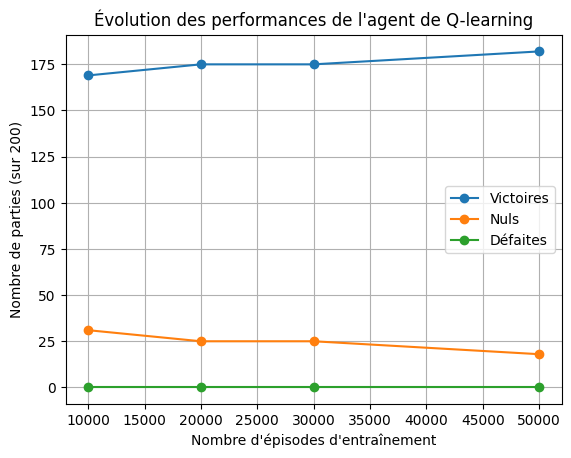

In [14]:
import matplotlib.pyplot as plt

episodes = [10000, 20000, 30000, 50000]
victoires = [169, 175, 175, 182]
defaites = [0, 0, 0, 0]
nuls = [31, 25, 25, 18]

plt.figure()
plt.plot(episodes, victoires, marker='o', label="Victoires")
plt.plot(episodes, nuls, marker='o', label="Nuls")
plt.plot(episodes, defaites, marker='o', label="Défaites")

plt.xlabel("Nombre d'épisodes d'entraînement")
plt.ylabel("Nombre de parties (sur 200)")
plt.title("Évolution des performances de l'agent de Q-learning")
plt.legend()
plt.grid(True)
plt.show()

### Graphiques de comparaison avec des pourcenatages

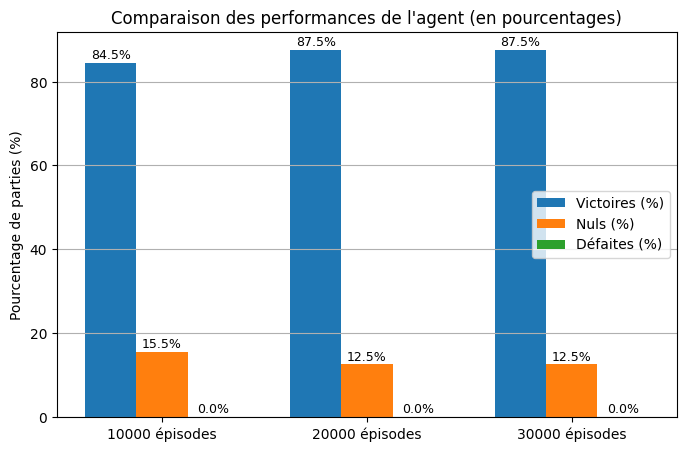

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Nombre total de parties
total_games = 200

# Données issues des évaluations
episodes = [10000, 20000, 30000]

wins = [169, 175, 175]
losses = [0, 0, 0]
draws = [31, 25, 25]

# Conversion en pourcentages
wins_pct = [w / total_games * 100 for w in wins]
losses_pct = [l / total_games * 100 for l in losses]
draws_pct = [d / total_games * 100 for d in draws]

# Position des barres
x = np.arange(len(episodes))
width = 0.25

# Création du graphique
plt.figure(figsize=(8,5))

bars_wins = plt.bar(x - width, wins_pct, width, label="Victoires (%)")
bars_draws = plt.bar(x, draws_pct, width, label="Nuls (%)")
bars_losses = plt.bar(x + width, losses_pct, width, label="Défaites (%)")

# Ajouter les pourcentages au-dessus des barres
for i, v in enumerate(wins_pct):
    plt.text(i - width, v + 1, f"{v:.1f}%", ha='center', fontsize=9)

for i, v in enumerate(draws_pct):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=9)

for i, v in enumerate(losses_pct):
    plt.text(i + width, v + 1, f"{v:.1f}%", ha='center', fontsize=9)

# Mise en forme
plt.xticks(x, [f"{e} épisodes" for e in episodes])
plt.ylabel("Pourcentage de parties (%)")
plt.title("Comparaison des performances de l'agent (en pourcentages)")
plt.legend()
plt.grid(axis='y')

plt.show()

Ce graphique met en évidence une amélioration progressive des performances
de l’agent avec l’augmentation du nombre d’épisodes d’entraînement. Le
taux de victoire augmente tandis que le taux de matchs nuls diminue, sans
observer de défaite.

### Analyse graphique

Plus le nombre d’épisodes d’entraînement augmente, plus les performances de l’agent s’améliorent : le nombre de victoires augmente progressivement, le nombre de matchs nuls diminue et aucune défaite n’est observée, ce qui indique une convergence vers une stratégie quasi optimale.

## Interface graphique -Vscode

Une interface Pygame peut être ajoutée pour permettre les modes :
- Humain vs Humain
- Humain vs agent
- Agent vs agent